In [174]:
!unzip Fashion.zip

流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: Fashion/images/82648243.jpg  
  inflating: __MACOSX/Fashion/images/._82648243.jpg  
  inflating: Fashion/images/102541956.jpg  
  inflating: __MACOSX/Fashion/images/._102541956.jpg  
  inflating: Fashion/images/102986658.jpg  
  inflating: __MACOSX/Fashion/images/._102986658.jpg  
  inflating: Fashion/images/166089789.jpg  
  inflating: __MACOSX/Fashion/images/._166089789.jpg  
  inflating: Fashion/images/106251543.jpg  
  inflating: __MACOSX/Fashion/images/._106251543.jpg  
  inflating: Fashion/images/193484632.jpg  
  inflating: __MACOSX/Fashion/images/._193484632.jpg  
  inflating: Fashion/images/120808915.jpg  
  inflating: __MACOSX/Fashion/images/._120808915.jpg  
  inflating: Fashion/images/192158693.jpg  
  inflating: __MACOSX/Fashion/images/._192158693.jpg  
  inflating: Fashion/images/152304339.jpg  
  inflating: __MACOSX/Fashion/images/._152304339.jpg  
  inflating: Fashion/images/212375055.jpg  
  inflating: __MACOSX/Fashion/images/._2

In [175]:
!pip install gradio
!pip install faiss-cpu
import os
import json
import gradio as gr
import matplotlib.pyplot as plt
from PIL import Image
import shutil
from transformers import CLIPProcessor, CLIPModel
import torch
import faiss
import requests
import numpy as np

## Preprocess the data

Filter out the complete outfits and delete the incomplete or unreasonable ones

In [176]:
def has_enough_core_items(outfit, metadata, min_core_items=2):
    """
Determine whether the outfit contains enough "core outfit" items (such as tops, pants, skirts, coats, etc.)
Prevent outfits that are all accessories from being included in subsequent recommendations.
    """
    core_keywords = [
        "top", "shirt", "blouse", "jacket", "coat", "outerwear",
        "pants", "skirt", "jeans", "bottom", "dress"
    ]
    count = 0
    for item in outfit["items"]:
        iid = item["item_id"]
        if iid in metadata:
            text = (metadata[iid].get("title", "") + metadata[iid].get("description", "")).lower()
            if any(k in text for k in core_keywords):
                count += 1
    return count >= min_core_items

import json, os
with open("/content/Fashion/mini_train.json", "r") as f:
    train_data = json.load(f)

with open("/content/Fashion/mini_metadata.json", "r") as f:
    metadata = json.load(f)
filtered_outfits = [o for o in train_data if has_enough_core_items(o, metadata)]

print(f"Original outfit number: {len(train_data)}")
print(f"Keeped outfit number: {len(filtered_outfits)}")

Original outfit number: 2000
Keeped outfit number: 574


Visualize some samples of the outfit


--- Outfit #1 ---
208379919 — found
209322511 — found
202527970 — found
209940725 — found
211489236 — found


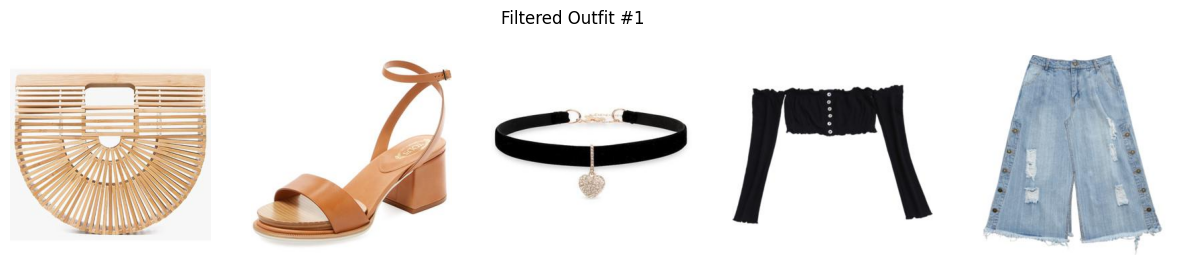


--- Outfit #2 ---
153218809 — found
144314772 — found
160708909 — found
141476256 — found


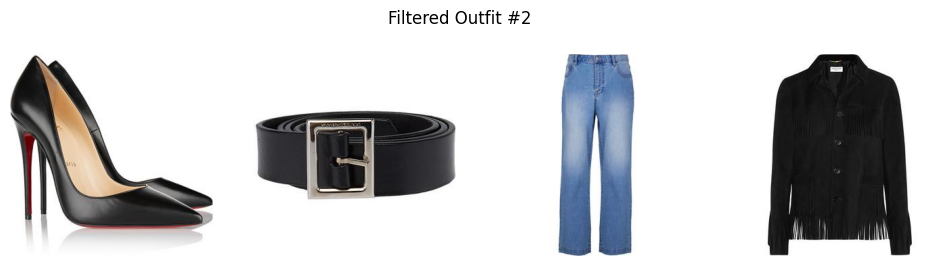


--- Outfit #3 ---
140057420 — found
136383010 — found
142551052 — found


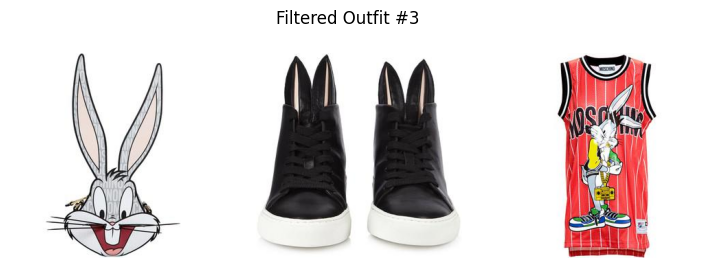


--- Outfit #4 ---
147889815 — found
152351685 — found
141076429 — found
146604895 — found
152230498 — found
152765982 — found
141478331 — found


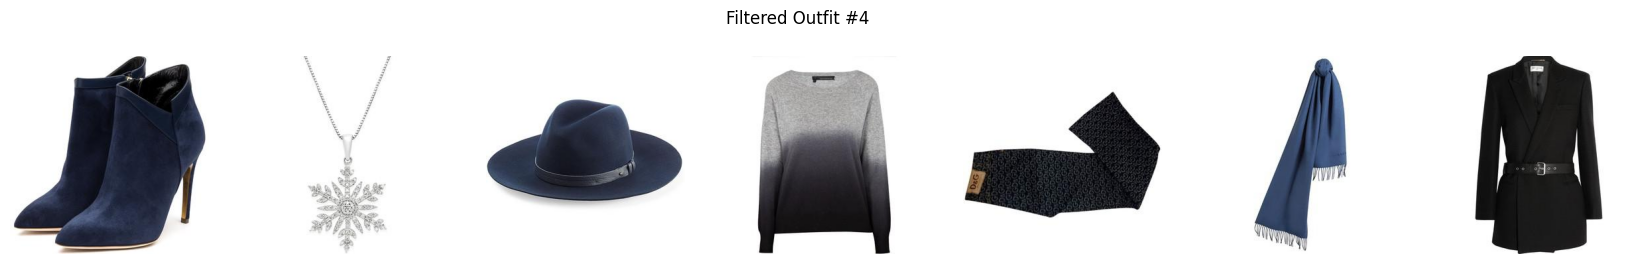


--- Outfit #5 ---
200036621 — found
193518007 — found
200111387 — found
195856260 — found
198245925 — found
200704066 — found
190525307 — found


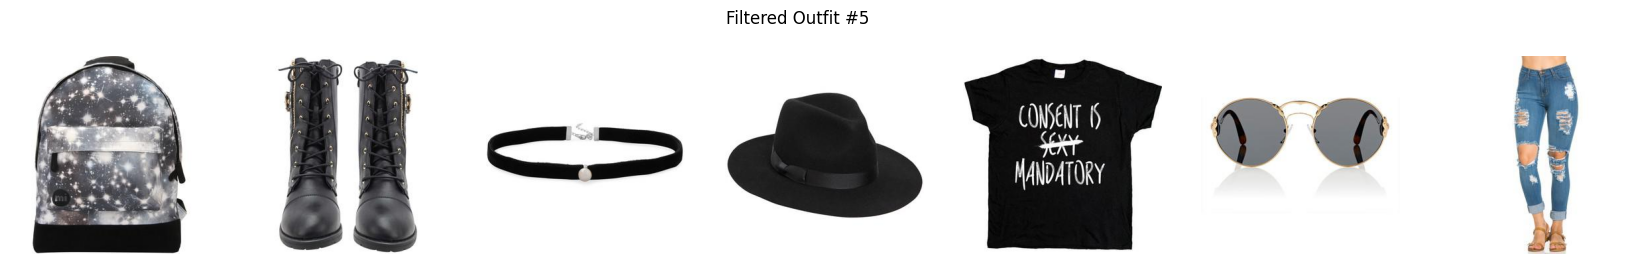

In [177]:
def show_filtered_outfits(outfits, image_dir, n=5):
    for i, outfit in enumerate(outfits[:n]):
        images = []
        print(f"\n--- Outfit #{i+1} ---")
        for item in outfit["items"]:
            iid = item["item_id"]
            img_path = os.path.join(image_dir, f"{iid}.jpg")
            if os.path.exists(img_path):
                try:
                    images.append(Image.open(img_path))
                    print(f"{iid} — found")
                except:
                    print(f"{iid} — load error")
            else:
                print(f"{iid} — not found")
        if images:
            fig, axes = plt.subplots(1, len(images), figsize=(3*len(images), 3))
            if len(images) == 1:
                axes = [axes]
            for ax, img in zip(axes, images):
                ax.imshow(img)
                ax.axis("off")
            plt.suptitle(f"Filtered Outfit #{i+1}")
            plt.show()
show_filtered_outfits(filtered_outfits, image_dir="/content/Fashion/images", n=5)

Load the prepared data

In [178]:
with open("/content/Fashion/filtered_train.json", "w") as f:
    json.dump(filtered_outfits, f, indent=2)
print("Saved to filtered_train.json")

original_image_dir = "/content/Fashion/images"
filtered_image_dir = "/content/Fashion/filtered_images"
os.makedirs(filtered_image_dir, exist_ok=True)

with open("/content/Fashion/filtered_train.json", "r") as f:
    filtered_outfits = json.load(f)
used_item_ids = set()
for outfit in filtered_outfits:
    for item in outfit["items"]:
        used_item_ids.add(item["item_id"])
for item_id in used_item_ids:
    src_path = os.path.join(original_image_dir, f"{item_id}.jpg")
    dst_path = os.path.join(filtered_image_dir, f"{item_id}.jpg")
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)
    else:
        print(f"Missing: {src_path}")
print(f"Saved {len(used_item_ids)} images to {filtered_image_dir}")

Saved to filtered_train.json
Saved 3401 images to /content/Fashion/filtered_images


## CLIP Embedding Functions for Text and Outfit Images

In [179]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def encode_text(text):
    try:
        inputs = clip_processor(text=[text], return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            text_features = clip_model.get_text_features(**inputs)
        # L2 normalize
        text_features = torch.nn.functional.normalize(text_features, p=2, dim=-1)
        return text_features.squeeze(0).cpu()
    except Exception as e:
        print(f"Failed to encode text '{text}': {e}")
        return None

def encode_image_clip_hf(image_path):
    try:
        img = Image.open(image_path).convert("RGB")
        inputs = clip_processor(images=img, return_tensors="pt").to(device)
        with torch.no_grad():
            image_features = clip_model.get_image_features(**inputs)
        image_features = torch.nn.functional.normalize(image_features, p=2, dim=-1)
        return image_features.squeeze(0).cpu()
    except Exception as e:
        print(f"Error encoding {image_path}: {e}")
        return None

def encode_outfit_images(image_paths):
    vecs = [encode_image_clip_hf(p) for p in image_paths if encode_image_clip_hf(p) is not None]
    if len(vecs) < 2:
        return None
    return torch.stack(vecs).mean(dim=0).cpu().numpy()

In [180]:
outfit_vectors = []
valid_outfits = []
base_path = "/content/Fashion"
image_path = os.path.join(base_path, "filtered_images")

for outfit in filtered_outfits:
    vecs = []
    for item in outfit["items"]:
        iid = item["item_id"]
        image_file = os.path.join(image_path, f"{iid}.jpg")
        vec = encode_image_clip_hf(image_file)
        if vec is not None:
            vecs.append(vec)
    if len(vecs) >= 2:
        outfit_vector = torch.stack(vecs).mean(dim=0)
        outfit_vectors.append(outfit_vector)
        valid_outfits.append(outfit)
print(f"generate {len(outfit_vectors)} outfit vector")

generate 574 outfit vector


In [52]:
embeddings = torch.stack(outfit_vectors).cpu().numpy()
faiss.normalize_L2(embeddings)
dim = embeddings.shape[1]
index = faiss.IndexFlatIP(dim)
index.add(embeddings)
print(f"Indexed {index.ntotal} outfits using FAISS.")

✅ Indexed 574 outfits using FAISS.


## Corporate the weather

In [181]:
def get_weather_category(location):
    API_KEY = "4d006bfa010d68bdb60dfd7298b2bdd8"
    BASE_URL = "https://api.openweathermap.org/data/2.5/weather"
    try:
        params = {
            "q": location,
            "appid": API_KEY,
            "units": "metric"
        }
        response = requests.get(BASE_URL, params=params)
        data = response.json()
        temp = data["main"]["temp"]
        condition = data["weather"][0]["main"].lower()

        print(f"🌡️ Temperature: {temp}°C | Condition: {condition}")

        if condition in ["rain", "drizzle", "thunderstorm"]:
            return "rainy"
        elif condition in ["snow", "mist", "ice"]:
            return "cold"
        elif temp < 10:
            return "cold"
        elif temp > 25:
            return "hot"
        else:
            return "normal"
    except Exception as e:
        print(f"Weather fetch error: {e}")
        return "normal"

## Input the text and weather, then recommend the suitable outfit

In [182]:
def build_query(text, location):
    weather_label = get_weather_category(location)
    return f"{text} outfit suitable for {weather_label} weather in {location}"

def recommend_outfit_from_text_and_location(text, location, top_k=3):
    query_text = build_query(text, location)
    print(f"🔍 Query: {query_text}")

    query_vec = encode_text(query_text)
    query_vec = np.array(query_vec).reshape(1, -1)
    faiss.normalize_L2(query_vec)

    D, I = index.search(query_vec, top_k * 3)
    candidates = [valid_outfits[i] for i in I[0]]
    D, I = index.search(query_vec, 10)

    weather_label = get_weather_category(location)
    return candidates[:top_k]
query = build_query("casual streetwear", "Norilsk")
print("✅ Final Query:", query)
print(get_weather_category("Norilsk"))
print(get_weather_category("Bangkok"))
print(get_weather_category("London"))

🌡️ Temperature: -5.07°C | Condition: clouds
✅ Final Query: casual streetwear outfit suitable for cold weather in Norilsk
🌡️ Temperature: -5.07°C | Condition: clouds
cold
🌡️ Temperature: 28.06°C | Condition: clouds
hot
🌡️ Temperature: 12.29°C | Condition: clear
normal


🌡️ Temperature: -5.07°C | Condition: clouds
🔍 Query: casual streetwear outfit suitable outfit suitable for cold weather in Norilsk
🌡️ Temperature: -5.07°C | Condition: clouds

--- Outfit #1 ---
195139714 — found
191896822 — found
185171863 — found
193558194 — found
192718137 — found
181780953 — found


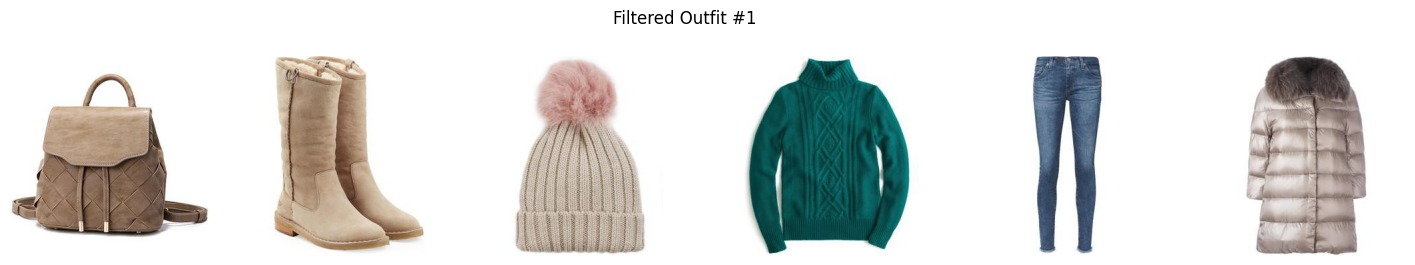


--- Outfit #2 ---
191092781 — found
179201834 — found
194375727 — found
195127827 — found
193618313 — found


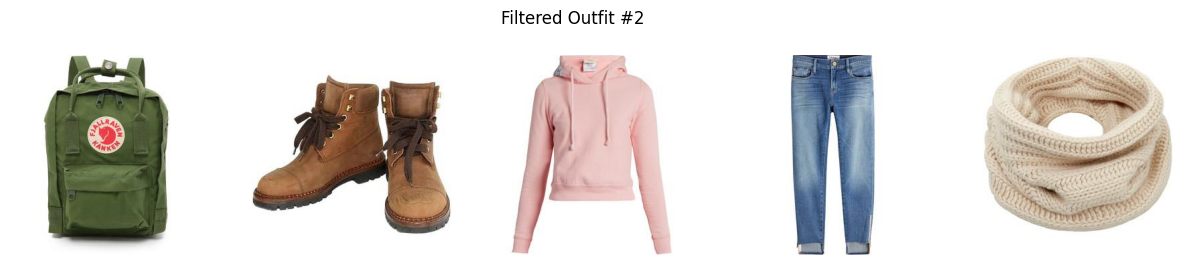


--- Outfit #3 ---
110827384 — found
211000131 — found
195803948 — found
160969480 — found
202171684 — found
208570359 — found
200882489 — found
136495320 — found
118161994 — found
195398745 — found
160565679 — found
149634273 — found
175400558 — found


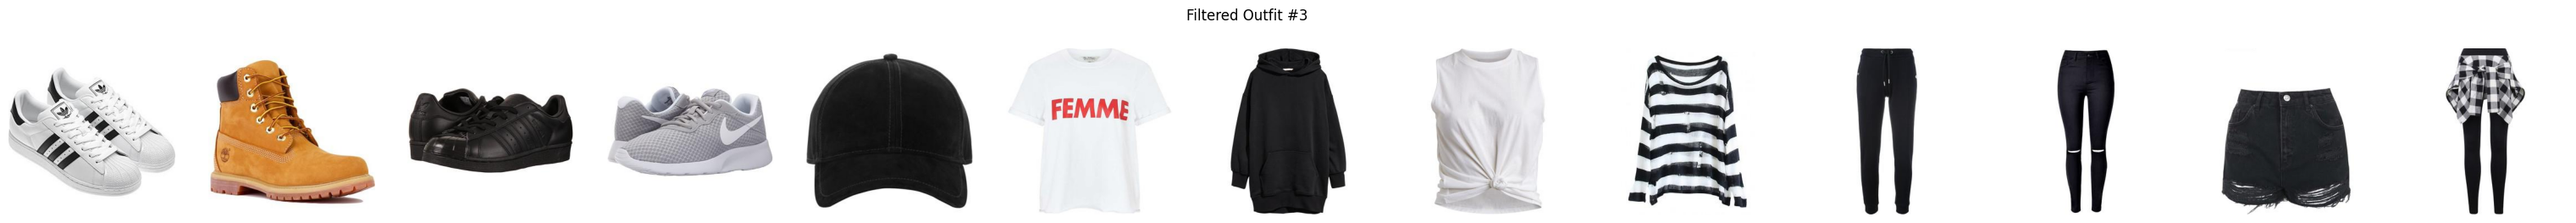

In [183]:
results = recommend_outfit_from_text_and_location("casual streetwear outfit suitable", "Norilsk")
show_filtered_outfits(results, image_dir="/content/Fashion/filtered_images")

🌡️ Temperature: 12.29°C | Condition: clear
🔍 Query:  casual streetwear outfit suitable outfit suitable for normal weather in London
🌡️ Temperature: 12.29°C | Condition: clear

--- Outfit #1 ---
110827384 — found
211000131 — found
195803948 — found
160969480 — found
202171684 — found
208570359 — found
200882489 — found
136495320 — found
118161994 — found
195398745 — found
160565679 — found
149634273 — found
175400558 — found


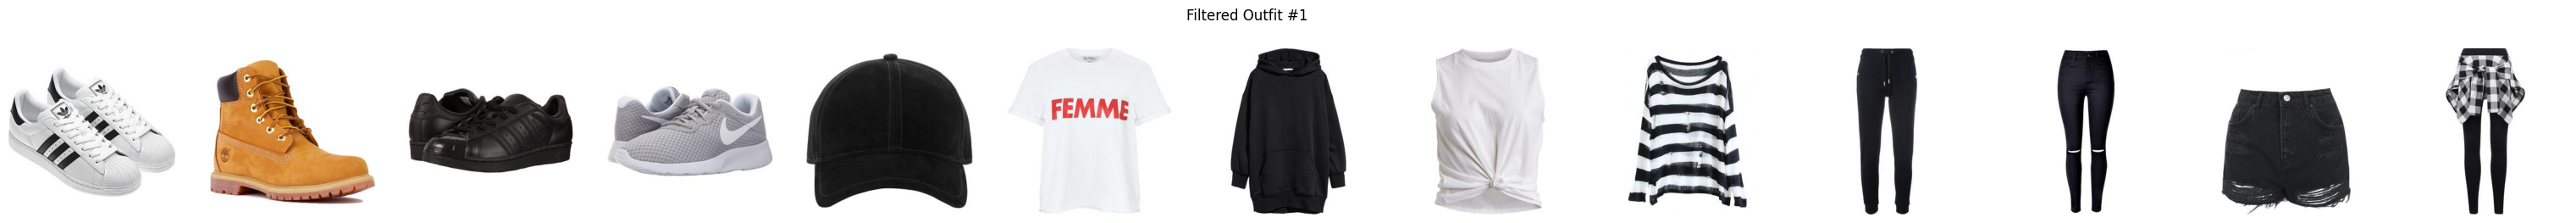


--- Outfit #2 ---
197025326 — found
189760358 — found
191377247 — found
199675858 — found
195207375 — found
184702914 — found


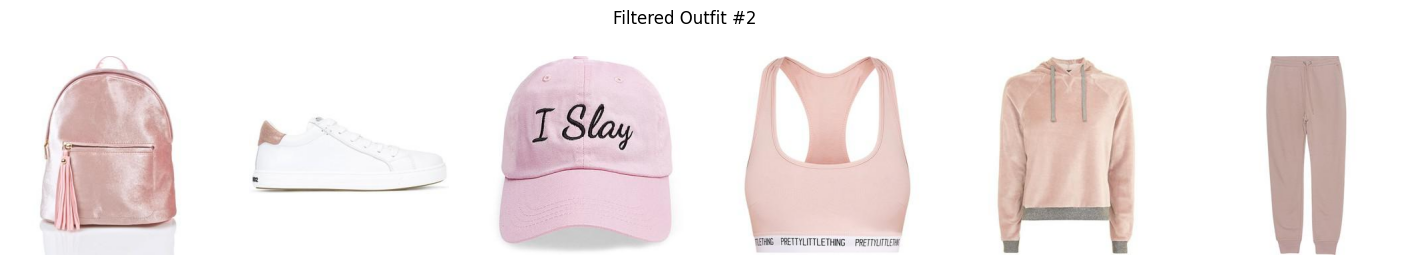


--- Outfit #3 ---
161211778 — found
184683537 — found
177658434 — found
120638063 — found


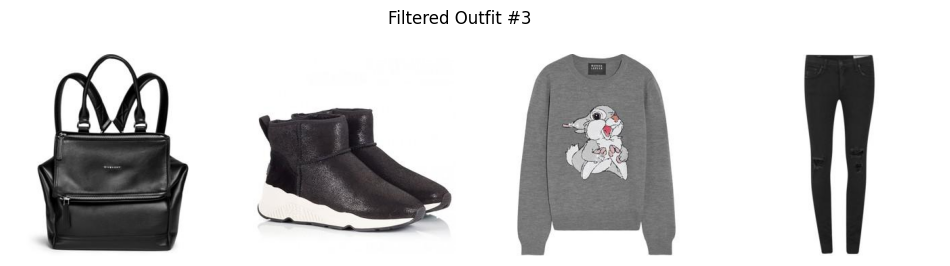

In [184]:
results = recommend_outfit_from_text_and_location(" casual streetwear outfit suitable", "London")
show_filtered_outfits(results, image_dir="/content/Fashion/filtered_images")

## Input the images, then recommend the similarity outfit

In [185]:
def recommend_outfits_from_uploaded_image(image_path, location, top_k=3):
    query_vec = encode_image_clip_hf(image_path)
    query_vec = np.array(query_vec, dtype="float32").reshape(1, -1)
    faiss.normalize_L2(query_vec)

    D, I = index.search(query_vec, top_k * 3)
    candidates = [valid_outfits[i] for i in I[0]]

    weather_label = get_weather_category(location)
    print(f"🌤️ Weather label for {location}: {weather_label}")
    return candidates[:top_k]

🌡️ Temperature: -5.07°C | Condition: clouds
🌤️ Weather label for Norilsk: cold

--- Outfit #1 ---
200412400 — found
205966847 — found
203215884 — found
124875036 — found
181588380 — found


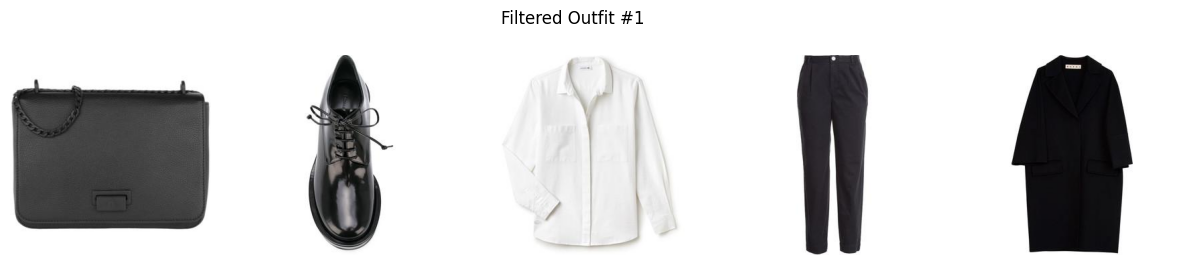


--- Outfit #2 ---
115347312 — found
115402246 — found
147756422 — found
126391172 — found
110413457 — found


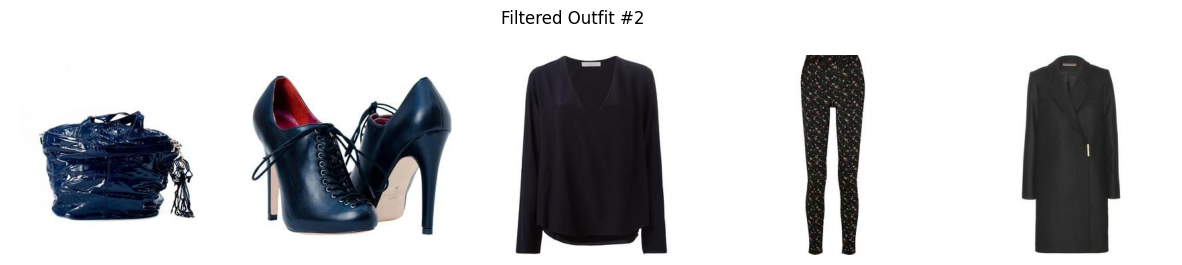


--- Outfit #3 ---
183232651 — found
201998436 — found
152244790 — found
133692891 — found
150342026 — found


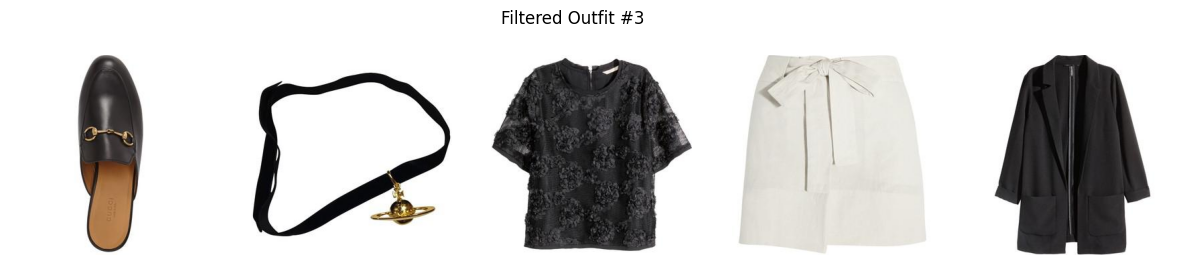

In [187]:
results = recommend_outfits_from_uploaded_image("/content/Fashion/test.png", location="Norilsk", top_k=3)
show_filtered_outfits(results, image_dir="/content/Fashion/filtered_images")

## UI interface

In [188]:
def show_filtered_outfits_gr(outfits, image_dir):
    results = []
    for outfit in outfits:
        imgs = []
        for item in outfit["items"]:
            iid = item["item_id"]
            img_path = os.path.join(image_dir, f"{iid}.jpg")
            if os.path.exists(img_path):
                try:
                    img = Image.open(img_path).resize((224, 224))
                    imgs.append(img)
                except:
                    continue
        if imgs:
            total_width = sum(img.width for img in imgs)
            max_height = max(img.height for img in imgs)
            combined = Image.new("RGB", (total_width, max_height))
            x_offset = 0
            for img in imgs:
                combined.paste(img, (x_offset, 0))
                x_offset += img.width
            results.append(combined)
    return results
def recommend_from_text(text, city):
    results = recommend_outfit_from_text_and_location(text, city, top_k=3)
    return show_filtered_outfits_gr(results, image_dir="/content/Fashion/filtered_images")

def recommend_from_image(image, city):
    results = recommend_outfits_from_uploaded_image(image.name, city, top_k=3)
    return show_filtered_outfits_gr(results, image_dir="/content/Fashion/filtered_images")

with gr.Blocks() as demo:
    gr.Markdown("# 👗 Weather-Aware Fashion Outfit Recommender")

    with gr.Tab("📝 Text + Location"):
        gr.Markdown("### Describe your style + City name")
        text_input = gr.Textbox(label="Style Description", placeholder="e.g., casual, formal, summer streetwear")
        location_input1 = gr.Textbox(label="City", placeholder="e.g., London")
        submit_btn1 = gr.Button("Recommend")
        gallery1 = gr.Gallery(label="Outfits", columns=1, height=400)

        submit_btn1.click(fn=recommend_from_text,
                          inputs=[text_input, location_input1],
                          outputs=gallery1)

    with gr.Tab("📷 Image + Location"):
        gr.Markdown("### Upload a clothing image + City name")
        image_input = gr.File(label="Upload Image")
        location_input2 = gr.Textbox(label="City", placeholder="e.g., Tokyo")
        submit_btn2 = gr.Button("Recommend")
        gallery2 = gr.Gallery(label="Outfits", columns=1, height=400)

        submit_btn2.click(fn=recommend_from_image,
                          inputs=[image_input, location_input2],
                          outputs=gallery2)

demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://433c7d6002fbfe8970.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


🌡️ Temperature: 12.29°C | Condition: clear
🔍 Query: casual outfit suitable for normal weather in London
🌡️ Temperature: 12.29°C | Condition: clear
🌡️ Temperature: 12.23°C | Condition: clear
🌤️ Weather label for London: normal
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7877 <> https://433c7d6002fbfe8970.gradio.live
